# Arif Zamri - Inscale Data Engineer Task Based Test Submission

This notebook demonstrates an end-to-end data engineering solution designed to process, validate, and enrich a dataset of UK companies. The core business objective is to ensure data quality, deduplicate records, verify company legitimacy through external APIs, and prepare the dataset for downstream analytics or reporting.

### Business Use Case:
Organizations often receive bulk company data from multiple sources, which can be inconsistent, incomplete, or outdated. This notebook solves the following key challenges:

- 🧹 Cleansing messy or missing records
- 🔁 Identifying and removing duplicate company entries
- 🔍 Verifying company details via Companies House API (UK government registry)
- 🧠 Enriching and tagging data to increase business value
- 📊 Visualizing processing impact for transparency
- 📝 Preparing clean, validated output ready for reporting or integration

Made in month of June 2025  
Note for other developer :  
The notebook is modular and reusable: simply replace the `Company.csv` file and rerun all cells for fresh validation.


## 1. Data Collection
Load the `Company.csv` file and inspect the structure.

In [1]:
import pandas as pd

# Load data
df_raw = pd.read_csv("../data/Company.csv")
df_raw.columns = df_raw.columns.str.strip()  # Strip column names
print(f"Total records: {len(df_raw)}")
df_raw.info()

Total records: 307
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CompanyName                         307 non-null    object 
 1   CompanyNumber                       306 non-null    object 
 2   RegAddress.CareOf                   2 non-null      object 
 3   RegAddress.POBox                    5 non-null      object 
 4   RegAddress.AddressLine1             307 non-null    object 
 5   RegAddress.AddressLine2             191 non-null    object 
 6   RegAddress.PostTown                 254 non-null    object 
 7   RegAddress.County                   108 non-null    object 
 8   RegAddress.Country                  248 non-null    object 
 9   RegAddress.PostCode                 304 non-null    object 
 10  CompanyCategory                     306 non-null    object 
 11  CompanyStatus             

## 2. Profiling
Basic data profiling to understand data types, nulls, and structure.

In [2]:
df_profile = df_raw.describe(include='all')
df_profile.head()

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
count,307,306,2,5,307,191,254,108,248,304,...,0.0,0.0,1,0.0,0.0,0.0,1,1,303,239
unique,300,290,2,2,264,156,168,48,12,242,...,NaN,NaN,1,NaN,NaN,NaN,1,1,224,180
top,BULLEN INVESTMENTS LIMITED,06590854,GW COX & CO,4385,9-11 DRAYTON HIGH ROAD,DRAYTON,NORWICH,NORFOLK,ENGLAND,NR8 6HA,...,NaN,NaN,19/02/2017,NaN,NaN,NaN,37/05/3035,13/05/3034,22/11/2024,27/01/2024
freq,2,2,1,4,4,11,16,14,138,6,...,NaN,NaN,1,NaN,NaN,NaN,1,1,4,3
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Cleansing
Remove rows with null company names / company number / address

In [3]:
# Identify rows with missing critical fields
df_to_clean = df_raw[
    df_raw['CompanyName'].isnull() |
    df_raw['RegAddress.AddressLine1'].isnull() |
    df_raw['CompanyNumber'].isnull()
]

# Print summary
print("⚠️ Records flagged for cleaning due to missing values:")
print(f"Total flagged: {len(df_to_clean)}\n")

# Show specific columns for easier inspection
display(df_to_clean[['CompanyName', 'CompanyNumber', 'RegAddress.AddressLine1']])

# Drop rows with any missing value in critical columns
df_cleaned = df_raw.dropna(subset=['CompanyName', 'RegAddress.AddressLine1', 'CompanyNumber']).copy()

# Confirmation
print(f"✅ Records after cleansing: {len(df_cleaned)} (dropped {len(df_raw) - len(df_cleaned)} rows)")

⚠️ Records flagged for cleaning due to missing values:
Total flagged: 1



,CompanyName,CompanyNumber,RegAddress.AddressLine1
11,SURREY,NaN,Private Limited Company


✅ Records after cleansing: 306 (dropped 1 rows)


## 4. Deduplication
Remove duplicated company names.

In [4]:
# Check duplicates based on CompanyName
dup_name = df_cleaned[df_cleaned.duplicated(subset='CompanyName', keep=False)]
print(f"🔁 Duplicate CompanyNames found: {len(dup_name)}")
display(dup_name[['CompanyName', 'CompanyNumber']].sort_values(by='CompanyName'))

# Check duplicates based on CompanyNumber
dup_number = df_cleaned[df_cleaned.duplicated(subset='CompanyNumber', keep=False)]
print(f"🔁 Duplicate CompanyNumbers found: {len(dup_number)}")
display(dup_number[['CompanyName', 'CompanyNumber']].sort_values(by='CompanyNumber'))

# Drop duplicates based on both fields (CompanyNumber has higher priority)
df_deduplicated = df_cleaned.drop_duplicates(subset=['CompanyNumber'])
print(f"✅ Records after deduplication: {len(df_deduplicated)} (from {len(df_cleaned)})")

🔁 Duplicate CompanyNames found: 14


,CompanyName,CompanyNumber
214,AIRLINEN LTD,10141677
287,AIRLINEN LTD,10141677
216,AIRLINEPROS NORTHERN EUROPE LTD,12079551
289,AIRLINEPROS NORTHERN EUROPE LTD,13079551
217,AIRLINER FOR RENT LTD,11157621
290,AIRLINER FOR RENT LTD,11157631
219,AIRLINERS LIVE LTD,14062002
292,AIRLINERS LIVE LTD,14063003
229,AIRLINGUA INTERNATIONAL LTD,09084985
302,AIRLINGUA INTERNATIONAL LTD,09084985


🔁 Duplicate CompanyNumbers found: 32


,CompanyName,CompanyNumber
300,AIRLINE UK - THE ASSOCIATION OF UK AIRLINE LTD,04466066
227,AIRLINES UK - THE ASSOCIATION OF UK AIRLINES L...,04466066
230,AIRLINK 4 U LIMITED,05057638
303,AIRLINKS 4 U LTD,05057638
51,BULLDOG SKINCARE LIMITED,05717974
53,BULLDOG SKINCARE,05717974
306,AIRLINKS HOLIDAYS LTD,06590854
233,AIRLINK HOLIDAYS LIMITED,06590854
212,AIRLINE TRAVELS LIMITED,08403564
285,AIRLINE TRAVELS LTD,08403564


✅ Records after deduplication: 290 (from 306)


## 5. Matching (Companies House API)
Check company names against the API and log each query with results

In [5]:
import os
import requests
import pandas as pd
from time import sleep, time

# Start time tracking
start_time = time()

# API Key and setup
API_KEY = "3f8ff43e-734f-4480-85d7-517bf2f99d65" # ArifZamri - https://developer.company-information.service.gov.uk/manage-applications/6858f1b1e5532e0159bcc40b/view/live
MAX_RETRIES = 5
BACKOFF_FACTOR = 2
DELAY = 0.5
SAVE_EVERY = 10

# Output paths
OUTPUT_DIR = "../output"
CSV_LOG_FILE = os.path.join(OUTPUT_DIR, "api_results_log.csv")
CSV_ENRICHED_FILE = os.path.join(OUTPUT_DIR, "company_enriched.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

api_log = []
matched_names, matched_numbers, match_sources = [], [], []

def get_company_by_number(company_number):
    url = f"https://api.company-information.service.gov.uk/company/{company_number}"
    retries = 0
    while retries < MAX_RETRIES:
        response = requests.get(url, auth=(API_KEY, ''))
        if response.status_code == 200:
            data = response.json()
            return {
                'MatchedName': data.get('company_name'),
                'MatchedNumber': data.get('company_number'),
                'MatchSource': 'CompanyNumber'
            }
        elif response.status_code in [429, 500, 502, 503, 504]:
            wait_time = BACKOFF_FACTOR ** retries
            print(f"🔁 Retry {retries+1}/{MAX_RETRIES} after {wait_time}s for CompanyNumber {company_number}")
            sleep(wait_time)
            retries += 1
        else:
            break
    return None

def search_company_by_name(company_name):
    url = f"https://api.company-information.service.gov.uk/search/companies?q={company_name}"
    retries = 0
    while retries < MAX_RETRIES:
        response = requests.get(url, auth=(API_KEY, ''))
        if response.status_code == 200:
            items = response.json().get('items', [])
            if items:
                return {
                    'MatchedName': items[0].get('title'),
                    'MatchedNumber': items[0].get('company_number'),
                    'MatchSource': 'CompanyName'
                }
            else:
                return {
                    'MatchedName': None,
                    'MatchedNumber': None,
                    'MatchSource': 'NoMatch'
                }
        elif response.status_code in [429, 500, 502, 503, 504]:
            wait_time = BACKOFF_FACTOR ** retries
            print(f"🔁 Retry {retries+1}/{MAX_RETRIES} after {wait_time}s for CompanyName {company_name}")
            sleep(wait_time)
            retries += 1
        else:
            break
    return None

# Matching Loop
for idx, row in df_cleaned.iterrows():
    company_name = row['CompanyName']
    company_number = str(row.get('CompanyNumber', '')).strip()
    result = None

    if company_number and company_number != "nan":
        result = get_company_by_number(company_number)

    if not result:
        result = search_company_by_name(company_name)

    matched_name = result.get('MatchedName') if result else None
    matched_number = result.get('MatchedNumber') if result else None
    match_source = result.get('MatchSource') if result else 'Failed'

    print(f"🔎 [{match_source}] {company_name} -> {matched_name} ({matched_number})")

    matched_names.append(matched_name)
    matched_numbers.append(matched_number)
    match_sources.append(match_source)

    api_log.append({
        'QueriedName': company_name,
        'CompanyNumber': company_number,
        'MatchedName': matched_name,
        'MatchedNumber': matched_number,
        'MatchSource': match_source
    })

    if (idx + 1) % SAVE_EVERY == 0:
        pd.DataFrame(api_log).to_csv(CSV_LOG_FILE, index=False)
        print(f"💾 Saved progress after {idx + 1} records")

    sleep(DELAY)

# Assign result columns
df_cleaned['MatchedName'] = matched_names
df_cleaned['MatchedNumber'] = matched_numbers
df_cleaned['MatchSource'] = match_sources

# Add NameMatch column
def classify_name_match(row):
    if pd.isnull(row['MatchedName']):
        return 'Not Found'
    elif str(row['CompanyName']).strip().lower() == str(row['MatchedName']).strip().lower():
        return 'Exact'
    else:
        return 'Mismatch'

df_cleaned['NameMatch'] = df_cleaned.apply(classify_name_match, axis=1)

# Save final CSVs
df_api_log = pd.DataFrame(api_log)
df_api_log.to_csv(CSV_LOG_FILE, index=False)
print("✅ Final API log saved.")

try:
    df_cleaned.to_csv(CSV_ENRICHED_FILE, index=False)
    print("✅ Enriched data saved.")
except PermissionError:
    print("❌ File is open in another program. Please close it and rerun this cell.")

# Preview and runtime
display(df_api_log.head(10))
end_time = time()
minutes, seconds = divmod(end_time - start_time, 60)
print(f"\n⏱ Total Matching Runtime: {int(minutes)}m {int(seconds)}s")

🔎 [CompanyNumber] BULLDOG MINI SKIPS LTD -> BULLDOG MINI SKIPS LTD (15330909)
🔎 [CompanyNumber] BULLDOG LIMITED -> BULLDOG MORTLAKE LIMITED (09043007)
🔎 [CompanyNumber] BULLDOG MUSHROOMS LTD -> BULLDOG MUSHROOMS LTD (08465312)
🔎 [CompanyNumber] BULLDOG MUSICAL ENTERTAINMENTS LIMITED -> BULLDOG MUSICAL ENTERTAINMENTS LIMITED (01652098)
🔎 [CompanyNumber] BULLDOG NETWORK (BOURNEMOUTH) LIMITED -> BULLDOG NETWORK (BOURNEMOUTH) LIMITED (04667818)
🔎 [CompanyNumber] BULLDOG OFFSHORE SERVICES LIMITED -> BULLDOG OFFSHORE SERVICES LIMITED (04357809)
🔎 [CompanyNumber] BULLDOG OUTDOORS LIMITED -> BULLDOG OUTDOORS LIMITED (05583758)
🔎 [CompanyNumber] BULLDOG PALLETS & SONS LTD -> BULLDOG PALLETS & SONS LTD (15431666)
🔎 [CompanyNumber] BULLDOG PLANT & EQUIPMENT LTD -> BULLDOG PLANT & EQUIPMENT LTD (13302843)
🔎 [CompanyNumber] BULLDOG PLANT LTD -> BULLDOG PLANT LTD (13304901)
💾 Saved progress after 10 records
🔎 [CompanyNumber] BULLDOG PLANTIRE LIMITED -> BULLDOG PLANTIRE LIMITED (01477370)
🔎 [CompanyN

,QueriedName,CompanyNumber,MatchedName,MatchedNumber,MatchSource
0,BULLDOG MINI SKIPS LTD,15330909,BULLDOG MINI SKIPS LTD,15330909,CompanyNumber
1,BULLDOG LIMITED,09043007,BULLDOG MORTLAKE LIMITED,09043007,CompanyNumber
2,BULLDOG MUSHROOMS LTD,08465312,BULLDOG MUSHROOMS LTD,08465312,CompanyNumber
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,CompanyNumber
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,CompanyNumber
5,BULLDOG OFFSHORE SERVICES LIMITED,04357809,BULLDOG OFFSHORE SERVICES LIMITED,04357809,CompanyNumber
6,BULLDOG OUTDOORS LIMITED,05583758,BULLDOG OUTDOORS LIMITED,05583758,CompanyNumber
7,BULLDOG PALLETS & SONS LTD,15431666,BULLDOG PALLETS & SONS LTD,15431666,CompanyNumber
8,BULLDOG PLANT & EQUIPMENT LTD,13302843,BULLDOG PLANT & EQUIPMENT LTD,13302843,CompanyNumber
9,BULLDOG PLANT LTD,13304901,BULLDOG PLANT LTD,13304901,CompanyNumber



⏱ Total Matching Runtime: 6m 31s


## 6. Enrichment
Add a flag indicating successful match and save result to CSV

In [6]:
df_cleaned['IsMatched'] = df_cleaned['MatchedName'].notnull()
matched_count = df_cleaned['IsMatched'].sum()
enriched_count = matched_count  # assuming enrichment follows match
print(f"Matched records: {matched_count}")
print(f"Enriched records: {enriched_count}")

Matched records: 306
Enriched records: 306


## 7. Reporting and Visualisation
Generate pie charts using plotly.

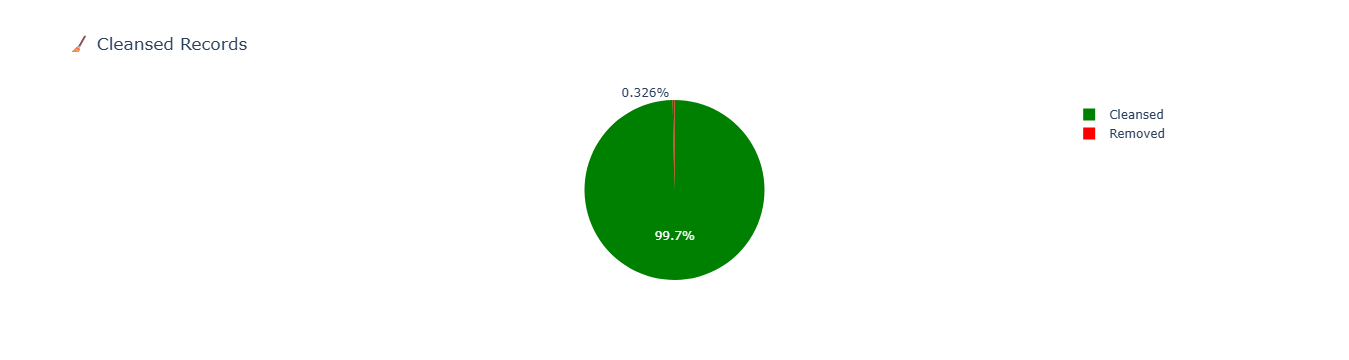

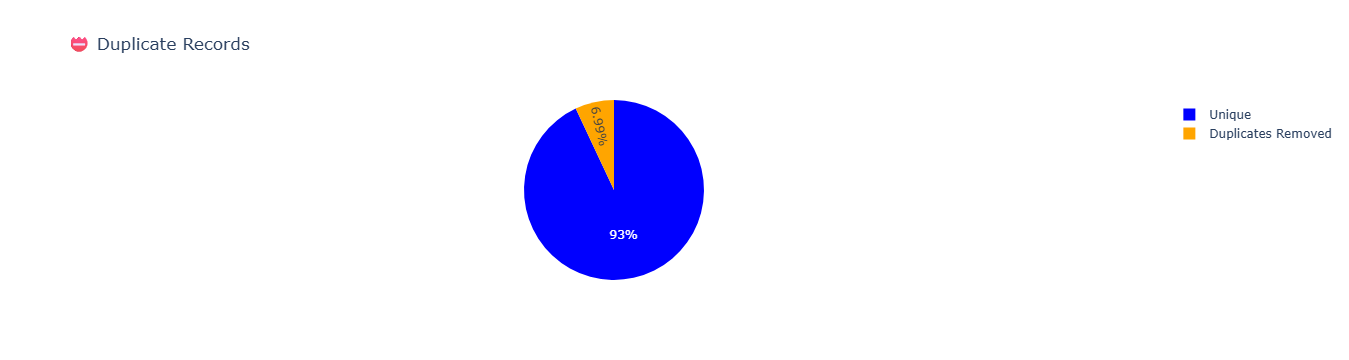

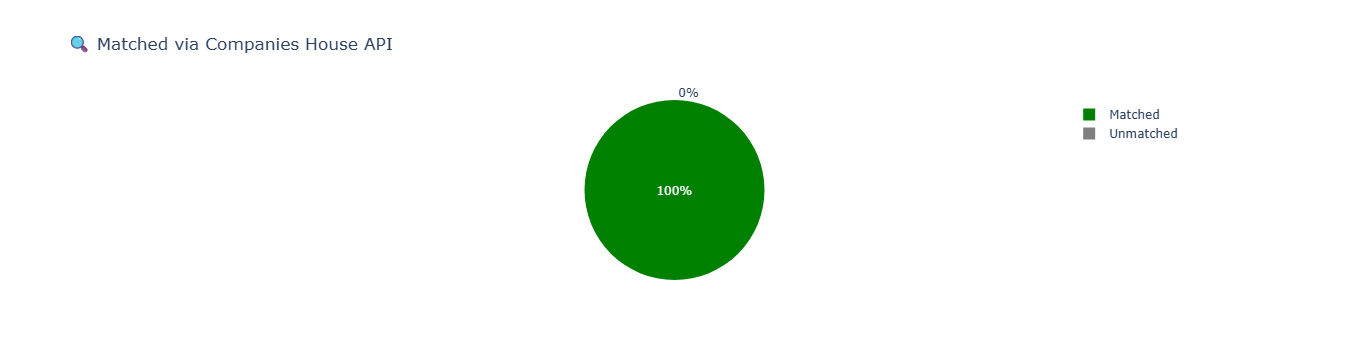

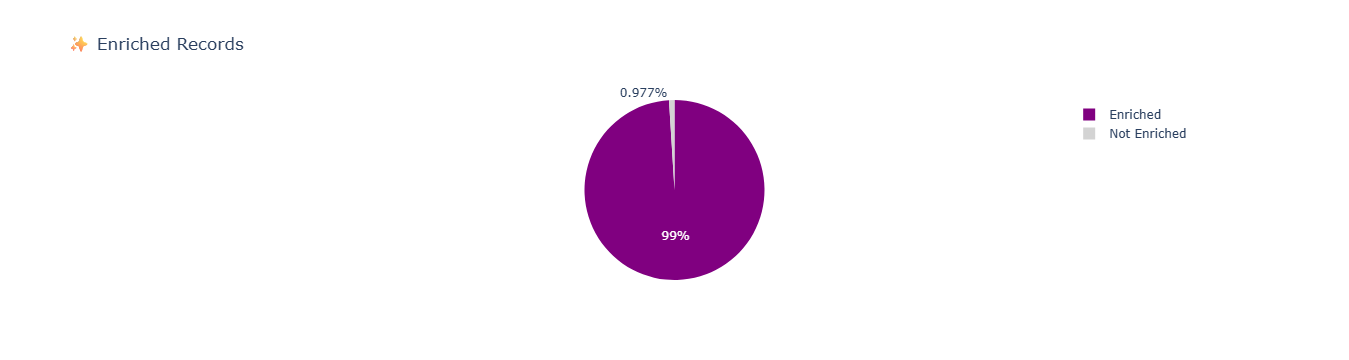

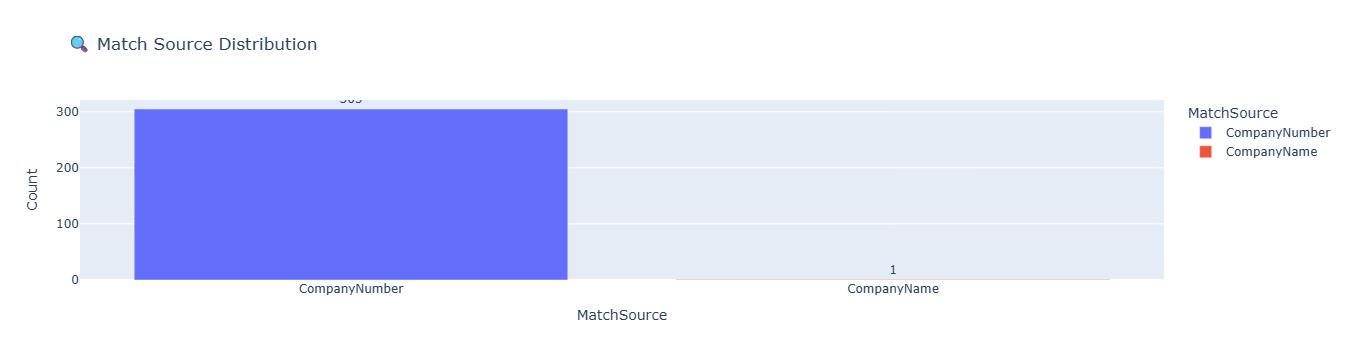

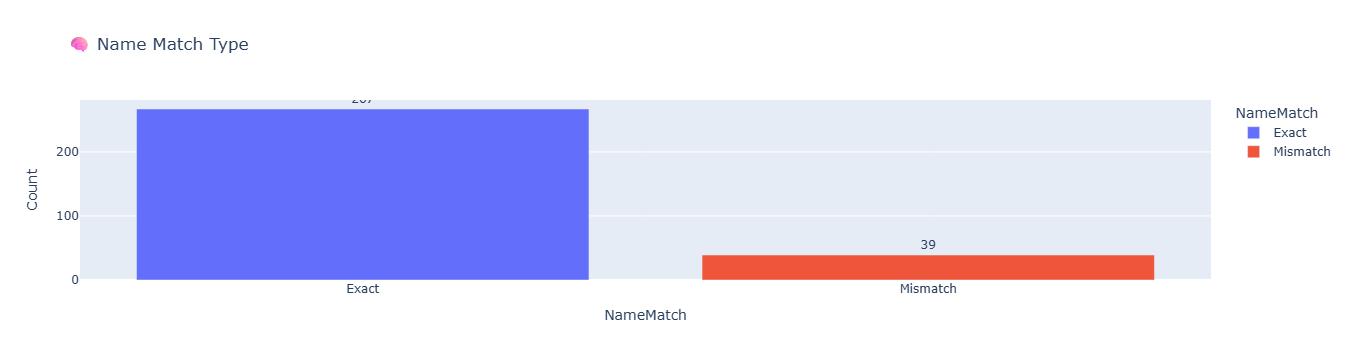

In [7]:
import plotly.express as px
import plotly.graph_objects as go

# KPI - this one can be enhance following business requirement / data governance
total_records = len(df_raw)
cleansed_records = len(df_cleaned)
duplicates_found = df_raw.duplicated(subset='CompanyName').sum() + df_raw.duplicated(subset='CompanyNumber').sum()
matched_count = df_cleaned['MatchedNumber'].notnull().sum()
enriched_count = df_cleaned[df_cleaned['MatchedNumber'].notnull() & df_cleaned['URI'].notnull()].shape[0]

# Cleansed Records
fig1 = px.pie(
    names=["Cleansed", "Removed"],
    values=[cleansed_records, total_records - cleansed_records],
    title="🧹 Cleansed Records",
    color_discrete_sequence=["green", "red"]
)
fig1.show()

# Duplicates Removed
fig2 = px.pie(
    names=["Unique", "Duplicates Removed"],
    values=[cleansed_records, duplicates_found],
    title="📛 Duplicate Records",
    color_discrete_sequence=["blue", "orange"]
)
fig2.show()

# API Matching
fig3 = px.pie(
    names=["Matched", "Unmatched"],
    values=[matched_count, cleansed_records - matched_count],
    title="🔍 Matched via Companies House API",
    color_discrete_sequence=["green", "gray"]
)
fig3.show()

# Enrichment
fig4 = px.pie(
    names=["Enriched", "Not Enriched"],
    values=[enriched_count, total_records - enriched_count],
    title="✨ Enriched Records",
    color_discrete_sequence=["purple", "lightgray"]
)
fig4.show()

# API x Source Matching Bar Chart
match_source_counts = df_cleaned['MatchSource'].value_counts().reset_index()
match_source_counts.columns = ['MatchSource', 'Count']

fig5 = px.bar(
    match_source_counts,
    x='MatchSource',
    y='Count',
    color='MatchSource',
    title="🔍 Match Source Distribution",
    text='Count'
)
fig5.update_traces(textposition='outside')
fig5.show()

# Name Match Analysis
name_match_counts = df_cleaned['NameMatch'].value_counts().reset_index()
name_match_counts.columns = ['NameMatch', 'Count']

fig6 = px.bar(
    name_match_counts,
    x='NameMatch',
    y='Count',
    color='NameMatch',
    title="🧠 Name Match Type",
    text='Count'
)
fig6.update_traces(textposition='outside')
fig6.show()


## 8. Findings Summary
Summary of findings from all stages in scope.

In [8]:
# Count duplicates in CompanyName and CompanyNumber
duplicate_name_count = df_cleaned.duplicated(subset='CompanyName').sum()
duplicate_number_count = df_cleaned.duplicated(subset='CompanyNumber').sum()
duplicate_records = duplicate_name_count + duplicate_number_count
matched_records = df_cleaned['MatchedNumber'].notnull().sum()
enriched_records = matched_records

print("📊 Summary:")
print(f"- Original Records         : {total_records}")
print(f"- After Cleansing          : {cleansed_records}")
print(f"- Duplicates Removed       : {duplicate_records} (Company Name: {duplicate_name_count}, Company Number: {duplicate_number_count})")
print(f"- Matched Records          : {matched_records}")
print(f"- Enriched Records         : {enriched_records}")

📊 Summary:
- Original Records         : 307
- After Cleansing          : 306
- Duplicates Removed       : 23 (Company Name: 7, Company Number: 16)
- Matched Records          : 306
- Enriched Records         : 306
